In [115]:
import os
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from scipy.linalg import sqrtm
from PIL import Image

## Algorithm

In [116]:
def sample_entry(M, delta):
    
    for i in range(M.shape[1]):
        sample = np.random.choice(2, M.shape[0], p=[1 - delta, delta])
        M[:, i] = M[:, i] * sample

    return M

In [117]:
def SPCA(C, k):
    omega = np.random.randn(C.shape[1], k)
    omega = sparse.lil_matrix(omega)
    
    #print ("gauss random matrix shape ", omega.shape)
    
    _C = sparse.lil_matrix(C.shape)
    
    # Trimming
    for i in range (C.shape[0]):
        if ((C.getrow(i).count_nonzero()) > 10):
            _C[i,:] = 0
        else:
            _C[i,:] = C[i,:]
    #print ("_C shape ", _C.shape)        
    
    diag_matrix = sparse.diags(diagonals=((_C.T @ _C).diagonal()), offsets=0, format="lil")
    
    F = _C.T @ _C - diag_matrix
    _power = int(np.ceil(5 * np.log(C.shape[1])))
        
    for i in range (_power):
        F = F @ F
        
    F = F @ omega
    u, _, _ = sparse.linalg.svds(F, k - 1)

    return u

In [118]:
def SLA(M, k, delta, l):
    
    M = M.astype(np.float64)
    
    m, n = M.shape[0], M.shape[1]
    #print ("k ", k)
    #print ("l ", l)
    #print ("M shape ", M.shape)
    
    #l_samples = list(np.random.choice(n, l, replace=True))
    l_samples = np.arange(l)
    
    #print ("sample len ", len(l_samples))
        
    A_b1 = sample_entry(M[:, l_samples], delta)
    A_b2 = sample_entry(M[:, l_samples], delta)
    #print("A_b1 shape ", A_b1.shape)

    A_b1 = sparse.lil_matrix(A_b1)
    A_b2 = sparse.lil_matrix(A_b2)    
    
    Q = SPCA(A_b1, k + 1)
    #print("Q shape ", Q.shape)
    
    M = np.delete(M, l_samples, 1)
    
    for i in range(m):
        if ((A_b2.getrow(i).count_nonzero()) > 2):
            A_b2[i, :] = 0
            
    for i in range(l):
        if ((A_b2.getcol(i).count_nonzero()) > 10 * delta * m):
            A_b2[:, i] = 0
    
    W = A_b2 @ Q
    V = np.zeros((n, k))
    
    #print("W shape", W.shape)
    #print("V shape", V.shape)
    
    V[:l, :] = (A_b1).T @ W
    
    ## FIXME: ??? what size ???
    I = A_b1 @ V[:l, :]
    #print("I shape 1", I.shape)
    
    ### TODO: Need to remove A_b1, A_b2 and Q from RAM
    
    for t in range(l, n):
        A_t = M[:, t - l]
        V[t, :] = A_t.reshape(1, -1) @ W
        I += A_t.reshape(-1, 1) @ V[t, :].reshape(1, -1)
    
    #print("I shape 2", I.shape)
    ## TODO: remove A_t from RAM ???

    #print("rank A_b1:", np.linalg.matrix_rank(A_b1))
    #print("rank A_b2:", np.linalg.matrix_rank(A_b2))
    #print("rank W:", np.linalg.matrix_rank(W))
    #print("rank Q:", np.linalg.matrix_rank(Q))
    #print("rank V:", np.linalg.matrix_rank(V))
    #print("rank I:", np.linalg.matrix_rank(I))
    
    R = sqrtm(V.T @ V)
    R = np.linalg.inv(R)
    
    #print("R shape", R.shape)
    
    U = (1.0/delta) * (I @ R @ R.T)
    
    ## FIXME: Need to find out what is here in actual algorithm
    M_k = U @ V.T
    #print(M_k.shape)
    
    filler = []
    
    for i in range(n-l-1, n-1):
        filler.append(M_k[:, i])
        filler.append(0.5 * (M_k[:, i] + M_k[:, i+1]))
    
    filler = np.array(filler).T
    
    M_k[:, :n-2*l] = M_k[:, l:n-l]
    M_k[:, n-2*l:] = filler
    
    return M_k      

## Evaluation

In [119]:
%matplotlib inline
from PIL import Image, ImageDraw
import requests

url = 'https://cdn.icon-icons.com/icons2/10/PNG/256/check_ok_accept_apply_1582.png'
img_raw = Image.open(requests.get(url, stream=True).raw)
img = np.array(img_raw).astype(np.uint8)

img = img[:,:,3]
image = np.zeros(img.shape).astype(dtype=np.int)
image[img >= 1] = 1


print (image.shape)
print (image)
print (np.count_nonzero(image))
print (image.shape[0] * image.shape[1])

(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
24485
65536


## Applications

### 1. Background/Foreground separation

In [120]:
def load_sequence_video(path, start, stop):
    
    files = sorted(os.listdir(path))
    frame = Image.open(os.path.join(path, files[0]))
    frame = frame.convert("L")
    frame = np.array(frame)
    
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, stop - start), np.float32)
    
    for i in range(start, stop):
        frame = Image.open(os.path.join(path, files[i])).convert("L")
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

def display_result_video(M, L, S, n_frames):
    n = M.shape[2]
    lst = np.random.choice(n, n_frames, replace=False)
    
    for i in range(len(lst)):
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(M[:,:,lst[i]], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(L[:,:,lst[i]], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(S[:,:,lst[i]], cmap='gray')
        plt.axis('off')

videos = [
            "./videos/Bootstrap",
            "./videos/Camouflage",
            "./videos/ForegroundAperture",
            "./videos/LightSwitch",
            "./videos/MovedObject",
            "./videos/TimeOfDay",
            "./videos/WavingTrees"
         ]

start = 0
stop = 3050
M_video, frame_size_video = load_sequence_video(videos[0], start, stop)

In [121]:
%%time

delta = 0.05
l = 20
k = 1

res_video = SLA(M_video.copy(), k, delta, l)

CPU times: user 7.98 s, sys: 1.07 s, total: 9.05 s
Wall time: 7.68 s


In [113]:
print("Approximated matrix rank:", np.linalg.matrix_rank(res_video))

Approximated matrix rank: 1


### Save videos for  separated background and foreground


In [221]:
import os

def save_bmps(orig_dst, back_dst, fore_dst, M, M_rec, frame_size):
    assert M.shape == M_rec.shape

    for j in range(M_rec.shape[1]):
        back_j = M_rec[:, j].reshape(frame_size)
        back_j = back_j / back_j.max()

        orig_j = M[:, j].reshape(frame_size)

        back_j = back_j * 255
        orig_j = orig_j * 255
        fore_j = np.clip(orig_j - back_j, 0, 255)
        
        full_j = np.concatenate([orig_j, back_j, fore_j], axis=1)
        full_j = Image.fromarray(full_j.astype(np.uint8))
        full_j.save(orig_dst + 'b{0:05d}.bmp'.format(j))

        #back_j = Image.fromarray(back_j.astype(np.uint8))
        #back_j.save(back_dst + 'b{0:05d}.bmp'.format(j))

        #fore_j = Image.fromarray(fore_j.astype(np.uint8))
        #fore_j.save(fore_dst + 'b{0:05d}.bmp'.format(j))

        #orig_j = Image.fromarray(orig_j.astype(np.uint8))
        #orig_j.save(orig_dst + 'b{0:05d}.bmp'.format(j))

In [222]:
back_dir = "./background/"
fore_dir = "./foreground/"
orig_dir = "./original/"

os.makedirs(back_dir, exist_ok=True)
os.makedirs(fore_dir, exist_ok=True)
os.makedirs(orig_dir, exist_ok=True)
save_bmps(orig_dir, back_dir, fore_dir, M_video, res_video, frame_size_video)

In [223]:
%%bash

function make_video {
    ffmpeg -v error -framerate 60 -i $1/b0%04d.bmp -r 60 -y $1.mp4
}

for dir in Bootstrap original background foreground; do
    make_video $dir
done

[image2 @ 0x560f8fdaf940] Could find no file with path 'Bootstrap/b0%04d.bmp' and index in the range 0-4
Bootstrap/b0%04d.bmp: No such file or directory


In [224]:
M_video_final = M_video.reshape(*frame_size_video, -1)
L_video_final = res_video.reshape(*frame_size_video, -1)
L_video_final = L_video_final / L_video_final.max()
S_video_final = np.maximum(0, M_video_final - L_video_final)
S_video_final[S_video_final < 0.3] = 0

np.count_nonzero(S_video_final) / np.prod(S_video_final.shape)

0.020373753415300545

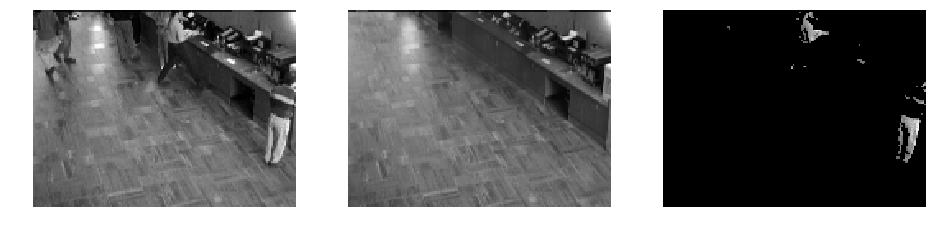

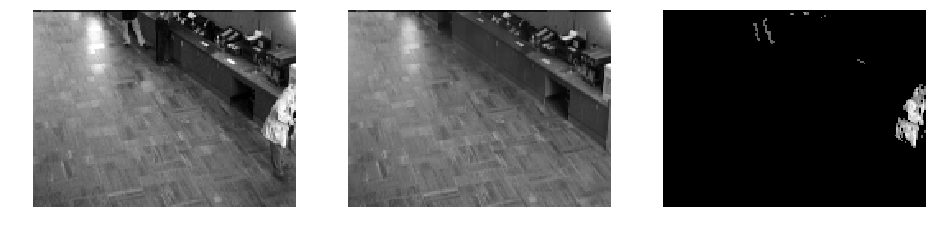

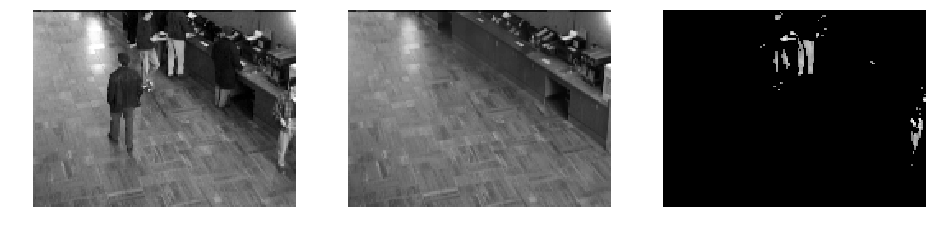

In [230]:
display_result_video(M_video_final,
                     L_video_final,
                     S_video_final, 3)

### 2. Shadow removing

In [257]:
path = "./CroppedYale/yaleB02"

def load_sequence_faces(path):
    files = sorted(os.listdir(path))[-58:]
    frame = Image.open(os.path.join(path, files[25]))

    frame = np.array(frame)
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, len(files)))
    
    for i in range(len(files)):
        frame = Image.open(os.path.join(path, files[i]))
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

M_faces, frame_size_faces = load_sequence_faces(path)

In [258]:
%%time

delta = 0.05
l = 5
k = 1

res_faces = SLA(M_faces.copy(), k, delta, l)

k  1
l  5
rank A_b1: 5
rank A_b2: 5
rank W: 1
rank Q: 1
rank V: 1
rank I: 1
R shape (1, 1)
CPU times: user 515 ms, sys: 19.8 ms, total: 535 ms
Wall time: 88.3 ms


In [259]:
M_faces_final = M_faces.reshape(*frame_size_faces, -1)
L_faces_final = res_faces.reshape(*frame_size_faces, -1)
L_faces_final = L_faces_final / L_faces_final.max()
S_faces_final = np.maximum(0, M_faces_final - L_faces_final)

In [264]:
def display_result_faces(M, L, S, n_frames):
    n = M.shape[2]
    lst = np.random.choice(n, n_frames, replace=False)
    
    for i in range(len(lst)):
        plt.figure(figsize=(10, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(M[:,:,lst[i]], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(L[:,:,lst[i]], cmap='gray')
        plt.axis('off')

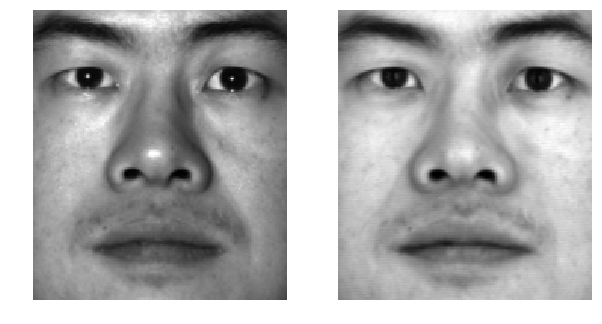

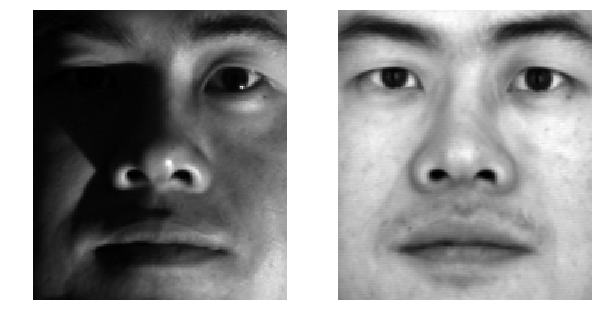

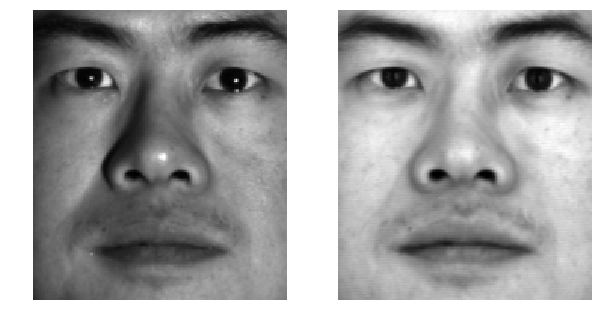

In [269]:
display_result_faces(M_faces_final,
                     L_faces_final,
                     S_faces_final, 3)